In [1]:
using Distributions
using Random
using StatsBase: ecdf
using StatsPlots
default(fmt=:png)

In [2]:
function pvalue_t(x; μ=0)
    n, x̄, s² = length(x), mean(x), var(x)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

pvalue_t (generic function with 1 method)

In [3]:
function pvalue_bootstrap(x; μ = 0,
        xbar = Vector{Float64}(undef, 10^4),
        xtmp = Vector{Float64}(undef, length(x))
    )
    for i in axes(xbar, 1)
        thid = Threads.threadid()
        sample!(x, xtmp)
        xbar[i] = mean(xtmp)
    end
    a = count(<(μ), xbar)
    b = count(>(μ), xbar)
    min(1, 2a/length(xbar), 2b/length(xbar))
end

pvalue_bootstrap (generic function with 1 method)

In [4]:
x = randn(100)
L = 10^4
xbar = Vector{Float64}(undef, L)
xtmp = Vector{Float64}(undef, length(x))
@time pvalue_bootstrap(x; xbar, xtmp)

  0.281405 seconds (449.80 k allocations: 22.162 MiB, 97.66% compilation time)


0.4868

In [5]:
function sim_pvals(; dist=Gamma(2,3), n=30, L=10^4, N=10^4)
    μ = mean(dist)
    nth = Threads.nthreads()
    xtmp = [Vector{Float64}(undef, n) for _ in 1:nth]
    xbartmp = [Vector{Float64}(undef, L) for _ in 1:nth]
    xtmptmp = [Vector{Float64}(undef, n) for _ in 1:nth]
    pval_t = Vector{Float64}(undef, N)
    pval_bs = Vector{Float64}(undef, N)
    Threads.@threads for i in 1:N
        thid = Threads.threadid()
        x = rand!(dist, xtmp[thid])
        pval_t[i] = pvalue_t(x; μ)
        pval_bs[i] = pvalue_bootstrap(x; μ, xbar=xbartmp[thid], xtmp=xtmptmp[thid])
    end
    pval_t, pval_bs
end

function plot_pvals(; dist=Gamma(2,3), n=30, L=10^4, N=10^4)
    @time pval_t, pval_bs = sim_pvals(; dist, n, L, N)
    
    ecdf_t = ecdf(pval_t)
    ecdf_bs = ecdf(pval_bs)
    f(α) = ecdf_t(α)
    g(α) = ecdf_bs(α)
    
    P1 = plot(legend=:topleft)
    plot!(f, 0, 1; label="one-sample t-test")
    plot!(g, 0, 1; label="bootstrap", ls=:dash)
    plot!([0,1], [0,1]; label="", ls=:dot, c=:black)
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    
    P2 = plot(legend=:topleft)
    plot!(f, 0, 0.1; label="one-sample t-test")
    plot!(g, 0, 0.1; label="bootstrap", ls=:dash)
    plot!([0,0.1], [0,0.1]; label="", ls=:dot, c=:black)
    plot!(xtick=0:0.01:1, ytick=0:0.01:1)    
    
    plot(P1, P2; size=(800, 400))
end

plot_pvals (generic function with 1 method)

  2.154635 seconds (307.94 k allocations: 16.467 MiB, 9.29% compilation time: 18% of which was recompilation)


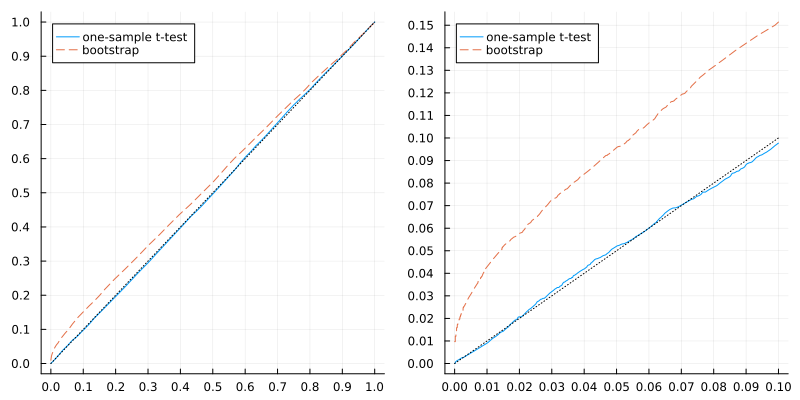

In [6]:
plot_pvals(; dist=Normal(), n=10, L=10^4, N=10^4)

  4.429929 seconds (168 allocations: 1.085 MiB)


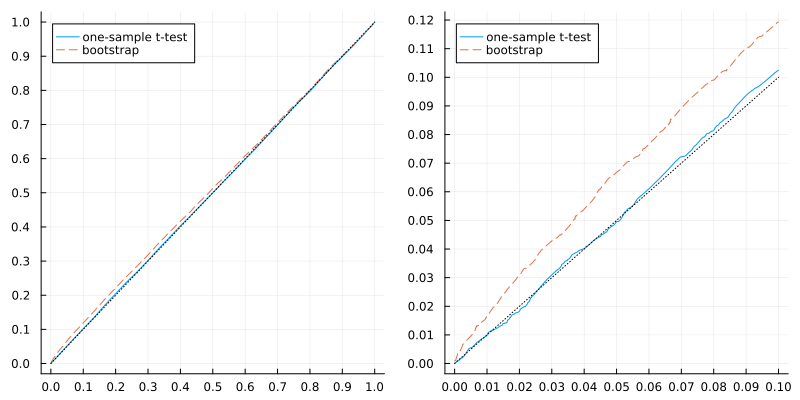

In [7]:
plot_pvals(; dist=Normal(), n=30, L=10^4, N=10^4)

 11.551970 seconds (152 allocations: 1.099 MiB)


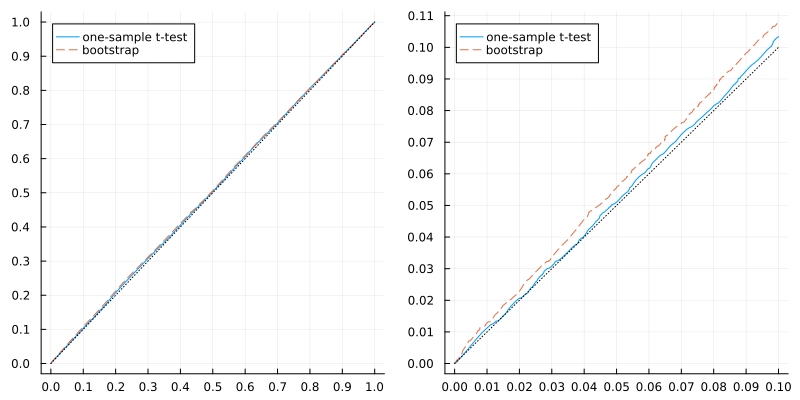

In [8]:
plot_pvals(; dist=Normal(), n=100, L=10^4, N=10^4)

  2.200960 seconds (323.00 k allocations: 17.623 MiB, 9.66% compilation time)


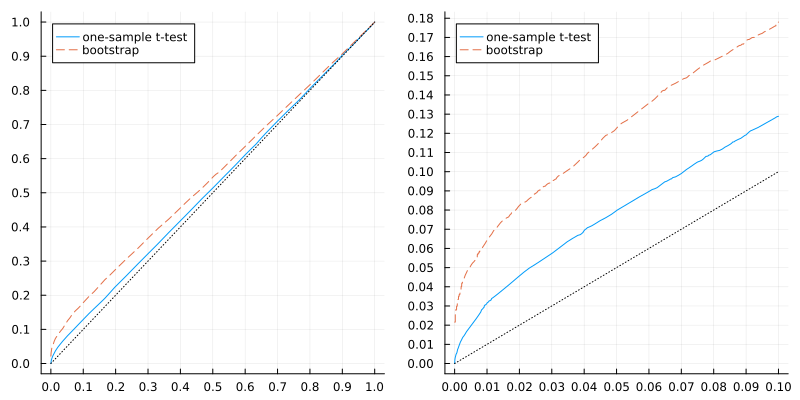

In [9]:
plot_pvals(; dist=Gamma(2,3), n=10, L=10^4, N=10^4)

  4.654451 seconds (162 allocations: 1.085 MiB)


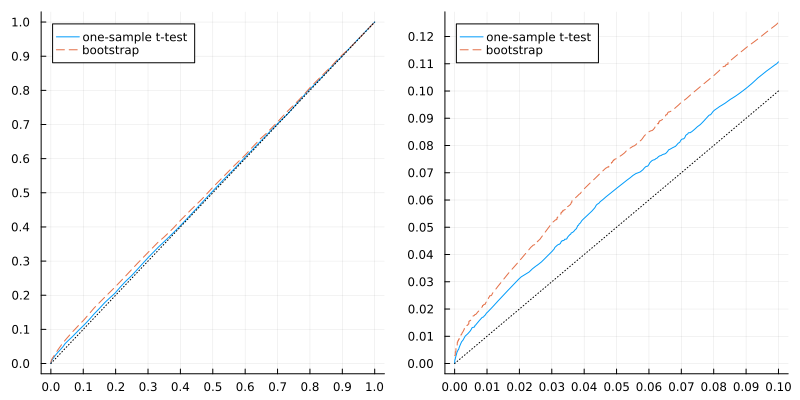

In [10]:
plot_pvals(; dist=Gamma(2,3), n=30, L=10^4, N=10^4)0

 11.963017 seconds (150 allocations: 1.099 MiB)


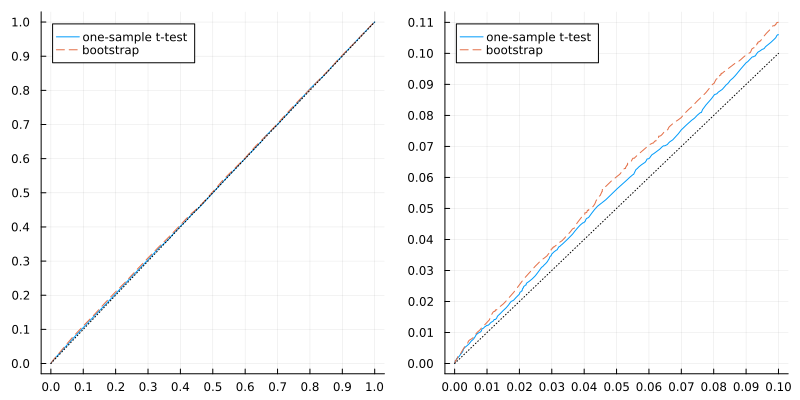

In [11]:
plot_pvals(; dist=Gamma(2,3), n=100, L=10^4, N=10^4)

  2.135774 seconds (146.87 k allocations: 8.630 MiB, 3.34% compilation time)


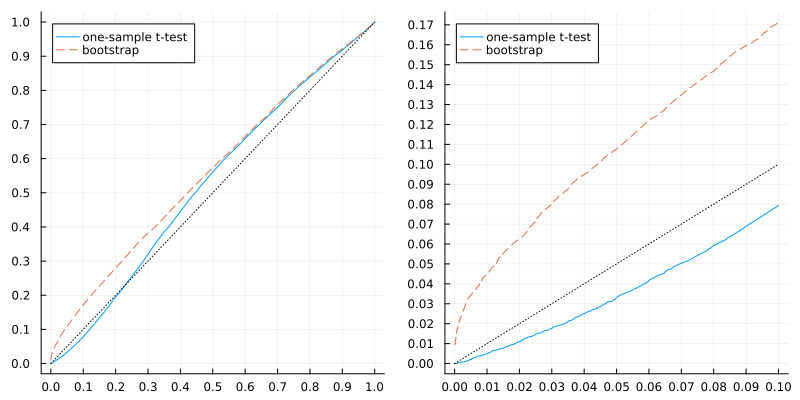

In [12]:
plot_pvals(; dist=TDist(2), n=10, L=10^4, N=10^4)

  4.603341 seconds (160 allocations: 1.085 MiB)


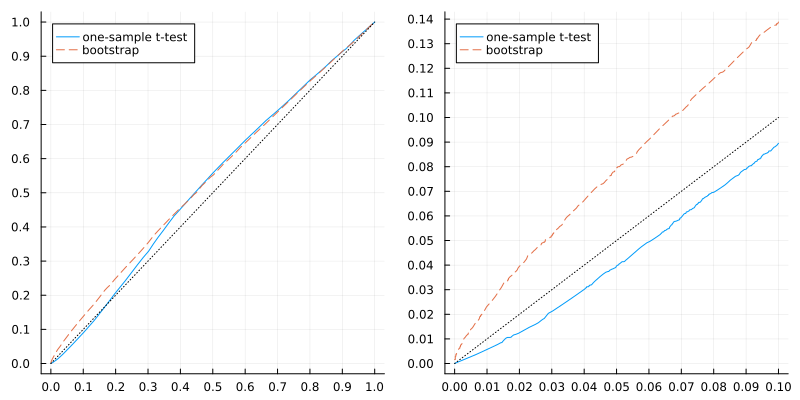

In [13]:
plot_pvals(; dist=TDist(2), n=30, L=10^4, N=10^4)

 12.060804 seconds (145 allocations: 1.098 MiB)


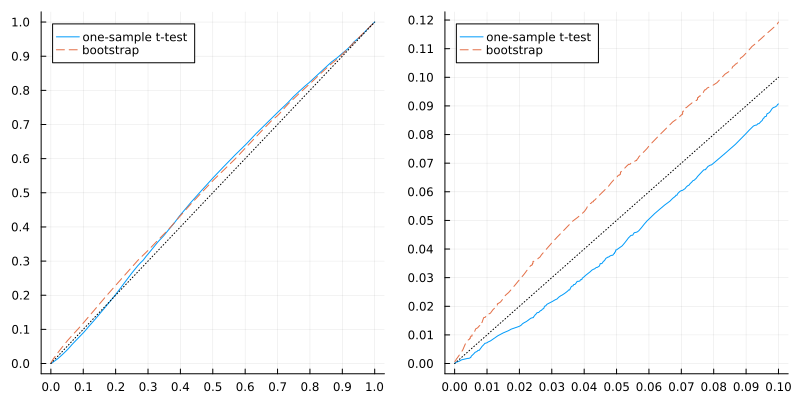

In [14]:
plot_pvals(; dist=TDist(2), n=100, L=10^4, N=10^4)

  1.968030 seconds (39.42 k allocations: 3.058 MiB, 1.96% compilation time)


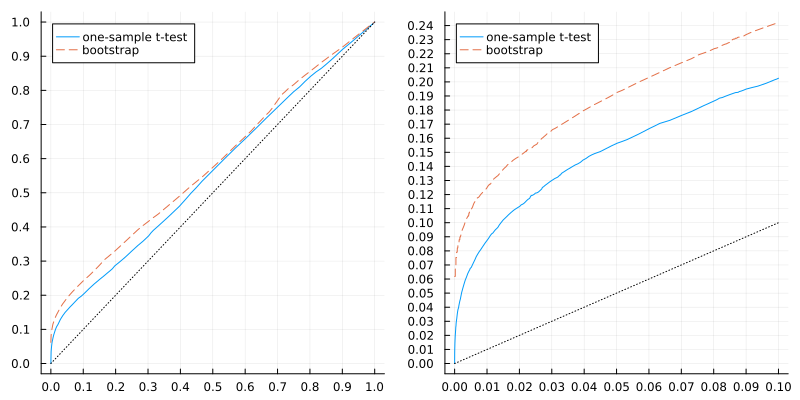

In [15]:
plot_pvals(; dist=LogNormal(), n=10, L=10^4, N=10^4)

  4.589970 seconds (165 allocations: 1.085 MiB)


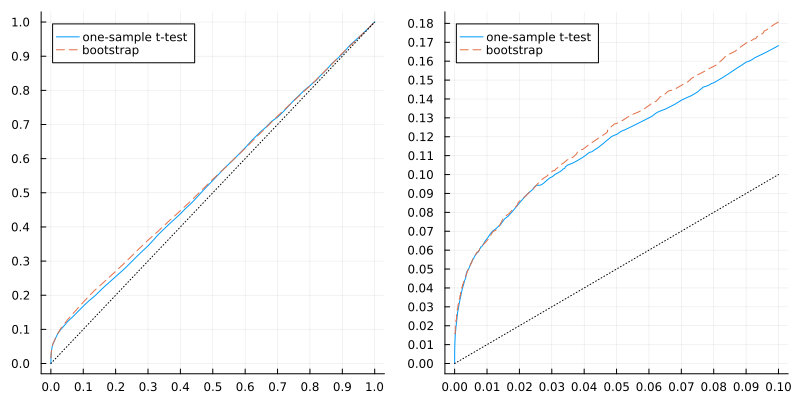

In [16]:
plot_pvals(; dist=LogNormal(), n=30, L=10^4, N=10^4)

 12.093973 seconds (145 allocations: 1.098 MiB)


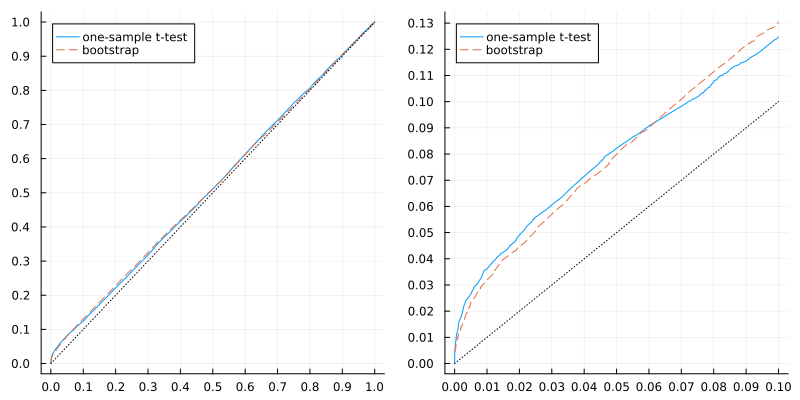

In [17]:
plot_pvals(; dist=LogNormal(), n=100, L=10^4, N=10^4)

 36.249612 seconds (173 allocations: 1.137 MiB)


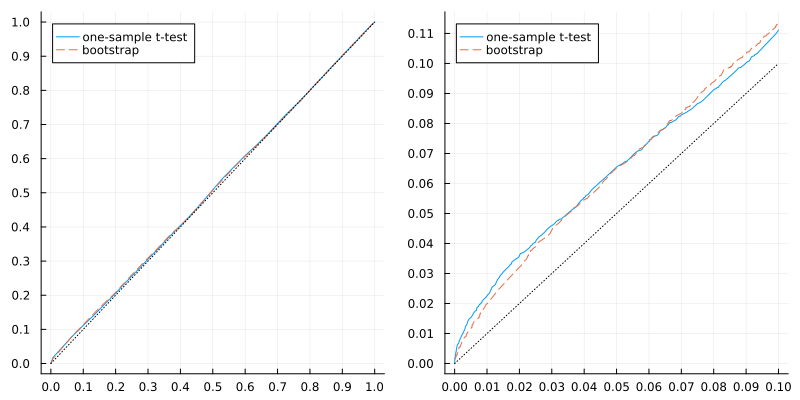

In [18]:
plot_pvals(; dist=LogNormal(), n=300, L=10^4, N=10^4)